## Visualization

In [1]:
# Initialization
import pandas as pd
import numpy as np

data = pd.read_csv('data.tsv', sep='\t')
data = data.dropna()

summaries = data.iloc[:, 2].values

In [2]:
# Pre-processing
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

stopword_set = set(stopwords.words('english'))
summaries_edited = []
for i, summary in enumerate(summaries):
    summary = re.sub('[^a-zA-Z]', ' ', summary)
    summary = summary.lower()
    summary = summary.split()
    summary = [x for x in summary if x not in stopword_set]
    summary = ' '.join([lemmatizer.lemmatize(x) for x in summary])
    summaries_edited.append(summary)


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000000, use_idf=True, ngram_range=(1,2))
tfidf_matrix = tfidf_vectorizer.fit_transform(summaries_edited)

In [4]:
from os.path import isfile
from gensim import corpora, models 

if isfile('dictionary.model'):
    dictionary = corpors.Dictionary.load('dictionary.model')
else:
    dictionary = corpora.Dictionary([x.split() for x in summaries_edited])
    dictionary.save('dictionary.model')
num_topics = n_ideal = 25
corpus = [dictionary.doc2bow(text) for text in [x.split() for x in summaries_edited]]
if isfile('lda.model'):
    lda = models.LdaModel.load('lda.model')
else:
    lda = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=0)

doc_topic = list() 
for doc in corpus: 
    doc_topic.append(lda.__getitem__(doc, eps=0))
    
for i, d in enumerate(doc_topic):
    for j, d_t in enumerate(d):
        doc_topic[i][j] = d_t[1]
doc_topic = np.array(doc_topic)

C:\opt\msys64\home\Rangga Garmastewira\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
# If necessary: Cleaning
threshold = 0.5
# indices = list(range(len(doc_topic)))
indices = np.amax(doc_topic, axis=1) > threshold
doc_topic = doc_topic[indices]
clusters = doc_topic.argmax(1)

# Create new data frame
data_new_values = { 'Title': data['Title'].values[indices], 'Summary': data['Summary'].values[indices], 'Content': data['Content'].values[indices], 'Cluster': clusters }
data_new = pd.DataFrame(data_new_values)
data_new['Cluster'].value_counts()

# See titles
cluster_title_dict = {}
for article in data_new.iloc[:, :].values:
    if article[0] not in cluster_title_dict:
        cluster_title_dict[article[0]] = []
    cluster_title_dict[article[0]].append(article[3])


In [6]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(doc_topic)
xs, ys = tsne_lda[:, 0], tsne_lda[:, 1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 683 samples in 0.002s...
[t-SNE] Computed neighbors for 683 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 683 / 683
[t-SNE] Mean sigma: 0.131878
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.764526
[t-SNE] Error after 1000 iterations: 0.403508


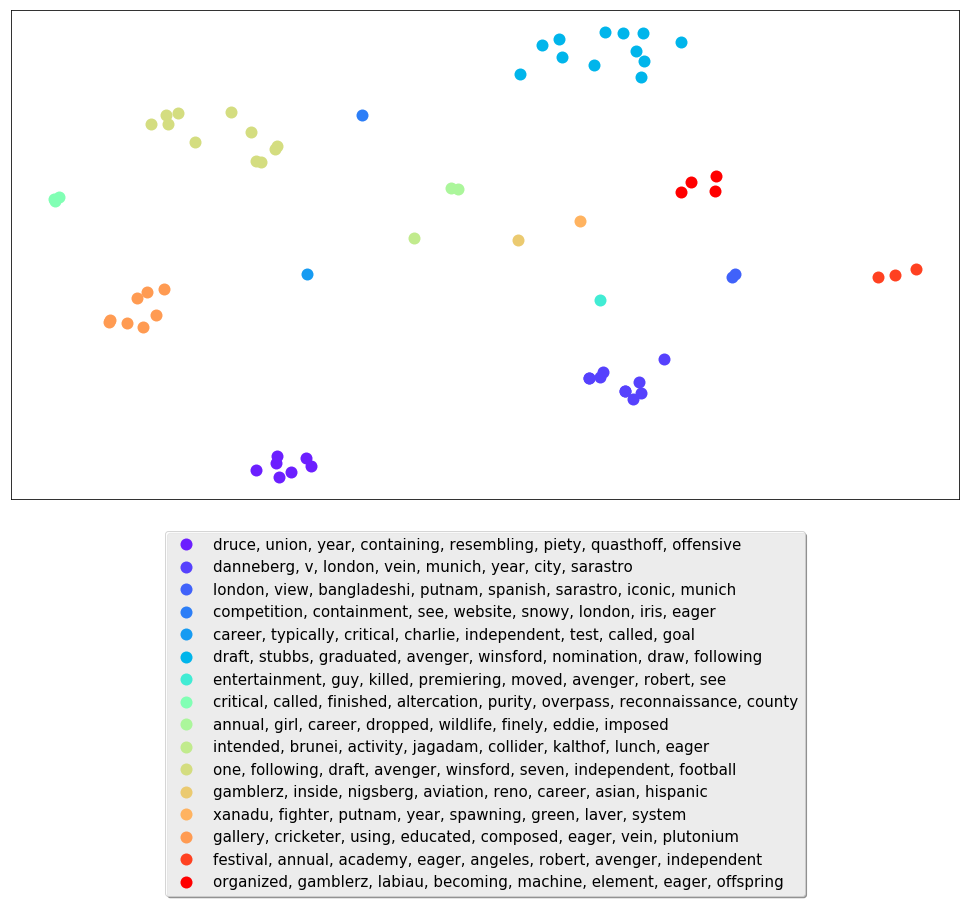

In [7]:
from matplotlib.pyplot import cm 
colors = cm.rainbow(np.linspace(0,1,n_ideal))
cluster_names = {}
for i in range(0, 25):
    terms = [dictionary[x[0]] for x in lda.get_topic_terms(i)[:8]]
    cluster_names[i] = ', '.join(terms)
    
titles = data['Title'].values
titles = titles[indices]
df = pd.DataFrame(dict(x=xs, y=ys, label=doc_topic.argmax(1), title=titles)) 
df = df.sample(frac=0.1, random_state=0)
groups = df.groupby('label')

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=colors[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

# for i in df.index:
   # ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=1, prop={'size': 15})
plt.show()

## Classification

In [19]:
import re
import numpy as np

def get_article_topic(article):
    global dictionary, lda, stopword_set
    temp = article.lower()

    words = re.findall(r'\w+', temp, flags = re.UNICODE)

    important_words = []
    important_words = filter(lambda x: x not in stopword_set, words)

    ques_vec = []
    ques_vec = dictionary.doc2bow(important_words)

    topic_vec = []
    topic_vec = lda[ques_vec]

    word_count_array = np.empty((len(topic_vec), 2), dtype = np.object)
    for i in range(len(topic_vec)):
        word_count_array[i, 0] = topic_vec[i][0]
        word_count_array[i, 1] = topic_vec[i][1]

    idx = np.argsort(word_count_array[:, 1])
    idx = idx[::-1]
    word_count_array = word_count_array[idx]
    return word_count_array[0:3, 0]


In [20]:
import pandas as pd
data = pd.read_csv('data_test.tsv', sep='\t', encoding='utf8')

In [32]:
topic_category_file = open('topic_category.txt', 'r', encoding='utf8')
lines = [x[:-1] for x in topic_category_file.readlines()]
topic_dict = {}
for line in lines:
    splits = line.split('\t')
    topic_dict[int(splits[0])] = splits[1]

In [33]:
def topics_to_categories(topics):
    global topic_dict
    categories = []

    for topic in topics:
        categories.append(topic_dict[topic])
    return categories


In [34]:
topics = []
for article in data['Content']:
    topics.append(topics_to_categories(get_article_topic(article)))


In [35]:
print(topics)

[['Art (Museum, Painting, Artist)', 'Sports', 'Series/Show'], ['Politics', 'Science & Engineering', 'Movies'], ['Science & Engineering', 'Movies', 'Music'], ['Movies', 'Science & Engineering', 'Politics'], ['Science & Engineering', 'Movies', 'Politics'], ['Non-English', 'Sports', 'Kingdoms'], ['Music', 'Politics', 'Sports'], ['Series/Show', 'Movies', 'Sports'], ['Politics', 'Series/Show', 'Movies'], ['Movies', 'Science & Engineering', 'Companies'], ['Famous Places', 'Education', 'Species'], ['Species', 'Series/Show', 'Species'], ['Movies', 'Music', 'Species'], ['Species', 'Movies', 'Series/Show'], ['War', 'Companies', 'Movies'], ['Species', 'Movies', 'War'], ['Species', 'Movies', 'War'], ['Species', 'Politics', 'Sports'], ['Species', 'Series/Show', 'Famous Places'], ['Non-English', 'Series/Show', 'Movies'], ['Music', 'Species', 'Radio/TV Channels'], ['Science & Engineering', 'Sports', 'Non-English'], ['Politics', 'Sports', 'Species'], ['Sports', 'Non-English', 'Music'], ['Movies', 'Kin